In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict
import CBFV 
from CBFV import composition



from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
plt.style.use(['fivethirtyeight'])

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

In [2]:
PATH = os.getcwd()

train_path = os.path.join(PATH,'C:/Users/M PRAVEEN/OneDrive/AMRITA/steel/cp_train.csv')
val_path = os.path.join(PATH, 'C:/Users/M PRAVEEN/OneDrive/AMRITA/steel/cp_val.csv')
test_path = os.path.join(PATH,'C:/Users/M PRAVEEN/OneDrive/AMRITA/steel/cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5190, 4)
df_val DataFrame shape: (1501, 4)
df_test DataFrame shape: (725, 4)


In [3]:
rename_dict = {'bulk modulus': 'target',
'formula':'formula'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 5190/5190 [00:00<00:00, 16448.11it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5190/5190 [00:00<00:00, 9969.13it/s] 



NOTE: Your data contains formula with exotic elements. These were skipped.
	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1501/1501 [00:00<00:00, 19294.41it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1501/1501 [00:00<00:00, 9707.64it/s]



NOTE: Your data contains formula with exotic elements. These were skipped.
	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 725/725 [00:00<00:00, 19130.02it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 725/725 [00:00<00:00, 9315.82it/s]



NOTE: Your data contains formula with exotic elements. These were skipped.
	Creating Pandas Objects...


In [4]:
X_train_unscaled.head()

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy,gap pbe,shear modulus
0,49.0,114.81800,5.0,13.0,5.0,1.0,0.0,0.0,75.0,1.0,...,2353.15,7.31,0.23,3.263,231.5,81.6,243.0,2.52,0.0,4.904836
1,12.0,24.30500,3.0,2.0,2.0,1.0,0.0,0.0,68.0,0.0,...,1363.15,1.74,1.02,8.954,127.4,156.0,148.0,1.51,0.0,1.830272
2,4.0,9.01218,2.0,2.0,2.0,1.0,0.0,0.0,67.0,0.0,...,3243.15,1.85,1.82,7.950,292.4,200.0,324.0,3.32,0.0,84.000000
3,72.0,178.49000,6.0,4.0,4.0,1.0,0.0,0.0,45.0,2.0,...,4873.15,13.30,0.14,24.060,575.0,23.0,619.0,6.44,0.0,44.836516
4,38.0,87.62000,5.0,2.0,2.0,1.0,0.0,0.0,8.0,0.0,...,1657.15,2.54,0.30,8.300,144.0,35.3,164.0,1.72,0.0,6.232662


In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)



In [6]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

X_train.shape

(5190, 310)

In [7]:
class DenseNet(nn.Module):
    """
    This implements a dynamically-built dense fully-connected neural network
    with leaky ReLU activation and optional dropout.

    Parameters
    ----------
    input_dims: int
        Number of input features (required).
    hidden_dims: list of ints
        Number of hidden features, where each integer represents the number of
        hidden features in each subsequent hidden linear layer (optional,
        default=[64, 32]).
    output_dims: int
        Number of output features (optional, default=1).
    dropout: float
        the dropout value (optional, default=0.0).
    """
    def __init__(self,
                 input_dims,
                 hidden_dims=[64, 32],
                 output_dims=1,
                 dropout=0.0):
        super().__init__()

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        self.dropout = dropout
        
        # Build a sub-block of linear networks
        def fc_block(in_dim, out_dim, *args, **kwargs):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim, *args, **kwargs),
                nn.Dropout(p=self.dropout),
                nn.LeakyReLU()
                )

        # Build overall network architecture
        self.network = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(input_dims, self.hidden_dims[0]),
                    nn.Dropout(p=self.dropout),
                    nn.LeakyReLU())
                ]
            )

        hidden_layer_sizes = zip(self.hidden_dims[:-1], self.hidden_dims[1:])
        self.network.extend([
            fc_block(in_dim, out_dim) for in_dim, out_dim
            in hidden_layer_sizes]
            )

        self.network.extend([
            nn.Linear(hidden_dims[-1], output_dims)]
            )


    def forward(self, x):
        """
        Forward pass of the DenseNet model.

        Parameters
        ----------
        x: torch.Tensor
            A representation of the chemical compounds in the shape
            (n_compounds, n_feats).

        Returns
        -------
        y: torch.Tensor
            The element property prediction with the shape 1.
        """
        for i, subnet in enumerate(self.network):
            x = subnet(x)
            
        y = x

        return y

In [8]:
CUDA_available = torch.cuda.is_available()
print(f'CUDA is available: {CUDA_available}')

if CUDA_available:
    compute_device = torch.device('cuda')
else:
    compute_device = torch.device('cpu')
    
print(f'Compute device for PyTorch: {compute_device}')

CUDA is available: False
Compute device for PyTorch: cpu


In [9]:
class CBFVDataLoader():
    """
    Parameters
    ----------
    train_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    val_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    test_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    batch_size: float, optional (default=64)
        Step size for the Gaussian filter
    random_state: int, optional (default=42)
        Random seed for sampling the dataset. Only used if validation data is
        not given.
    shuffle: bool, optional (default=True)
        Whether to shuffle the datasets or not
    """
    def __init__(self, train_data, val_data, test_data,
                 batch_size=64, num_workers=1, random_state=42,
                 shuffle=True, pin_memory=True):

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        self.shuffle = shuffle
        self.random_state = random_state


    def get_data_loaders(self, batch_size=1):
        '''
        Input the dataset, get train test split
        '''
        train_dataset = CBFVDataset(self.train_data)
        val_dataset = CBFVDataset(self.val_data)
        test_dataset = CBFVDataset(self.test_data)

        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  pin_memory=self.pin_memory,
                                  shuffle=self.shuffle)

        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                pin_memory=self.pin_memory,
                                shuffle=self.shuffle)

        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        return train_loader, val_loader, test_loader


class CBFVDataset(Dataset):
    """
    Get X and y from CBFV-based dataset.
    """
    def __init__(self, dataset):
        self.data = dataset

        self.X = np.array(self.data[0])
        self.y = np.array(self.data[1])
        self.shape = [(self.X.shape), (self.y.shape)]

    def __str__(self):
        string = f'CBFVDataset with X.shape {self.X.shape}'
        return string

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[[idx], :]
        y = self.y[idx]

        X = torch.as_tensor(X)
        y = torch.as_tensor(np.array(y))

        return (X, y)

In [10]:
train_data = (X_train, y_train)
val_data = (X_val, y_val)
test_data = (X_test, y_test)

# Instantiate the DataLoader
batch_size = 128
data_loaders = CBFVDataLoader(train_data, val_data, test_data, batch_size=batch_size)
train_loader, val_loader, test_loader = data_loaders.get_data_loaders()

In [11]:
# Get input dimension size from the dataset
example_data = train_loader.dataset.data[0]
input_dims = example_data.shape[-1]

# Instantiate the model
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
print(model)

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=310, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [12]:
# Initialize the loss criterion
criterion = nn.L1Loss()
print('Loss criterion: ')
print(criterion)

# Initialize the optimzer
optim_lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=optim_lr)
print('\nOptimizer: ')
print(optimizer)

Loss criterion: 
L1Loss()

Optimizer: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [13]:
# Move the model and criterion to the compute device
model = model.to(compute_device)
criterion = criterion.to(compute_device)

In [14]:
class Scaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (data - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled)
        data = data_scaled * self.std + self.mean
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


class MeanLogNormScaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.logdata = torch.log(self.data)
        self.mean = torch.mean(self.logdata)
        self.std = torch.std(self.logdata)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (torch.log(data) - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled) * self.std + self.mean
        data = torch.exp(data_scaled)
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [15]:
def predict(model, data_loader):
    target_list = []
    pred_list = []

    model.eval()
    with torch.no_grad():
        for i, data_output in enumerate(data_loader):
            X, y_act = data_output
            X = X.to(compute_device,
                     dtype=data_type,
                     non_blocking=True)
            y_act = y_act.cpu().flatten().tolist()
            y_pred = model.forward(X).cpu().flatten().tolist()

            # Unscale target values
            y_pred = target_scaler.unscale(y_pred).tolist()

            targets = y_act
            predictions = y_pred
            target_list.extend(targets)
            pred_list.extend(predictions)
    model.train()

    return target_list, pred_list


def evaluate(target, pred):
    r2 = r2_score(target, pred)
    mae = mean_absolute_error(target, pred)
    rmse = mean_squared_error(target, pred, squared=False)
    output = (r2, mae, rmse)
    return output


def print_scores(scores, label=''):
    r2, mae, rmse = scores
    print(f'{label} r2: {r2:0.4f}')
    print(f'{label} mae: {mae:0.4f}')
    print(f'{label} rmse: {rmse:0.4f}')
    return scores


def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='cyan', alpha=0.4,)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

In [16]:
y_train = [data[1].numpy().tolist() for data in train_loader]
y_train = [item for sublist in y_train for item in sublist]

y_train = train_loader.dataset.y

target_scaler = MeanLogNormScaler(y_train)

epoch: 0
train r2: -0.0557
train mae: 62.4552
train rmse: 98.5199
val r2: -0.0513
val mae: 59.9555
val rmse: 74.6374


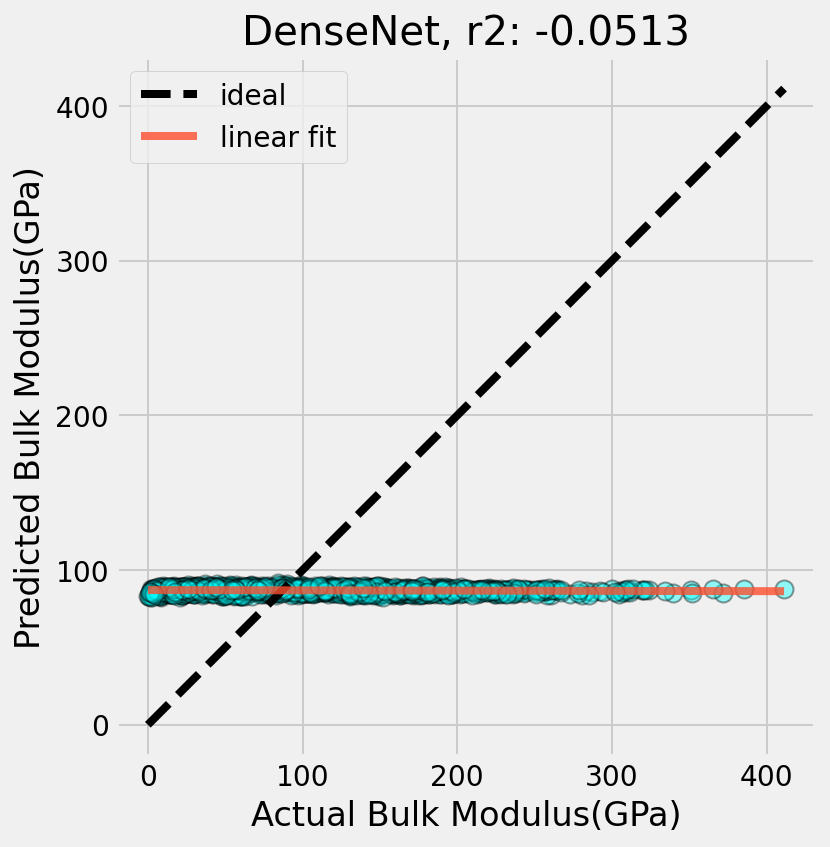

epoch: 20
epoch: 40
epoch: 60
epoch: 80
epoch: 100
train r2: 0.5521
train mae: 11.1234
train rmse: 64.1717
val r2: 0.9264
val mae: 11.8078
val rmse: 19.7469


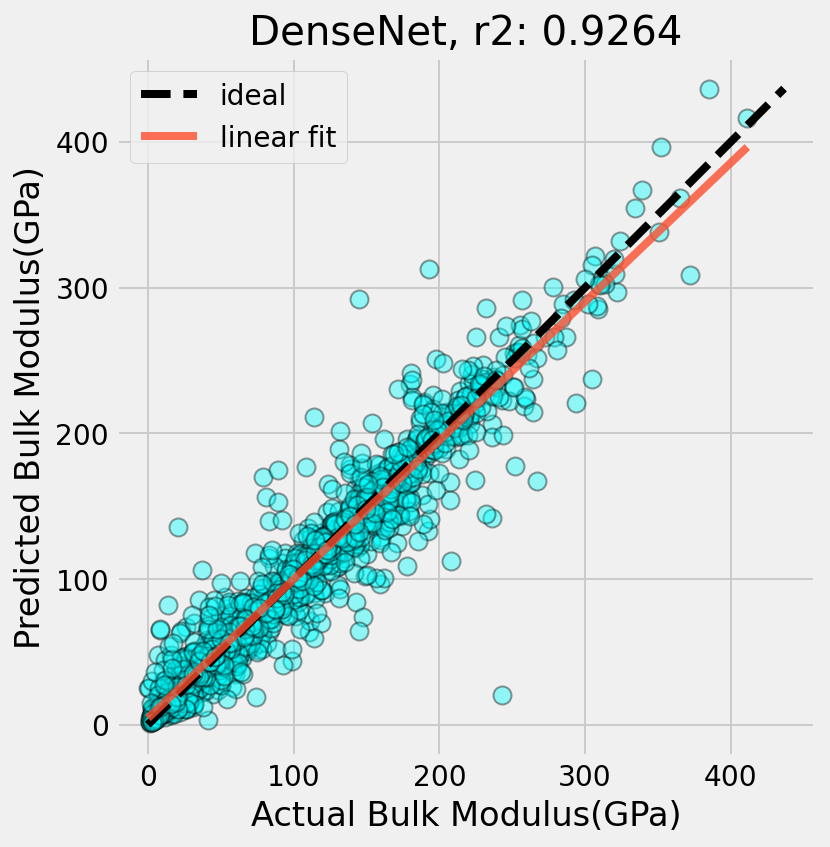

epoch: 120
epoch: 140
epoch: 160
epoch: 180
epoch: 200
train r2: 0.5620
train mae: 10.9683
train rmse: 63.4576
val r2: 0.9224
val mae: 12.5220
val rmse: 20.2836


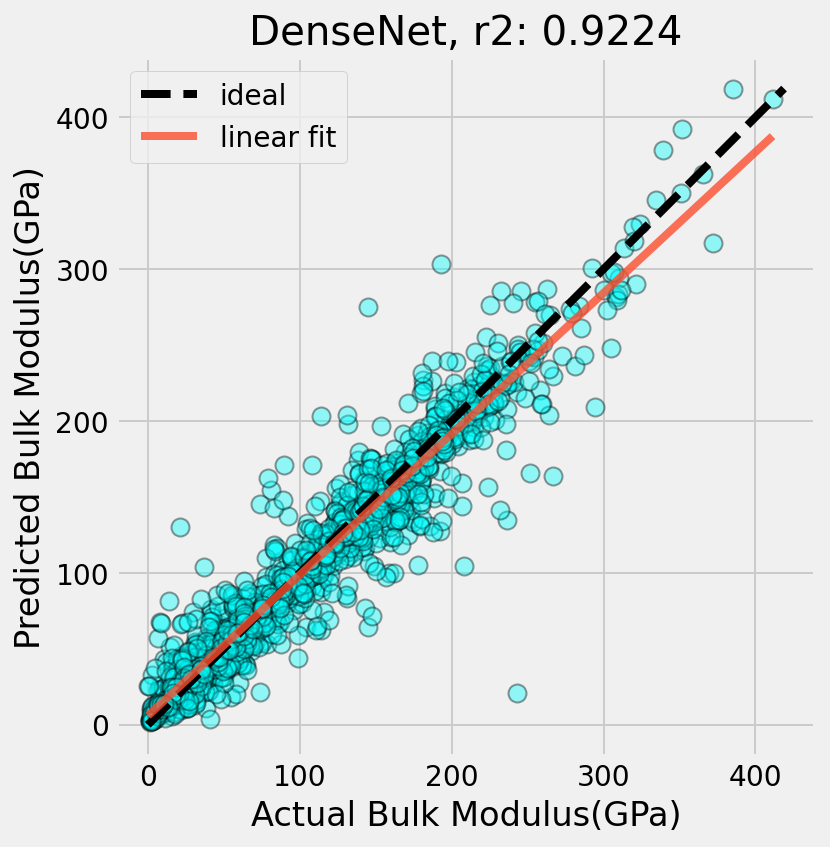

epoch: 220
epoch: 240
epoch: 260
epoch: 280
epoch: 300
train r2: 0.5666
train mae: 10.4814
train rmse: 63.1252
val r2: 0.9250
val mae: 12.0780
val rmse: 19.9297


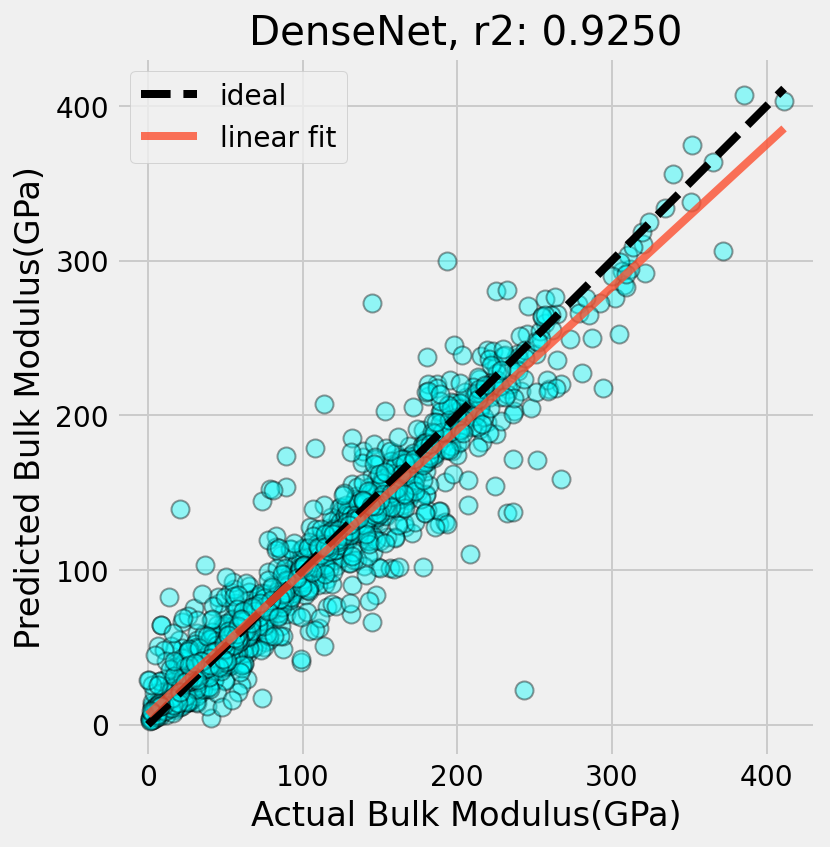

epoch: 320
epoch: 340
epoch: 360
epoch: 380
epoch: 400
train r2: 0.5687
train mae: 10.5310
train rmse: 62.9691
val r2: 0.9255
val mae: 12.1146
val rmse: 19.8668


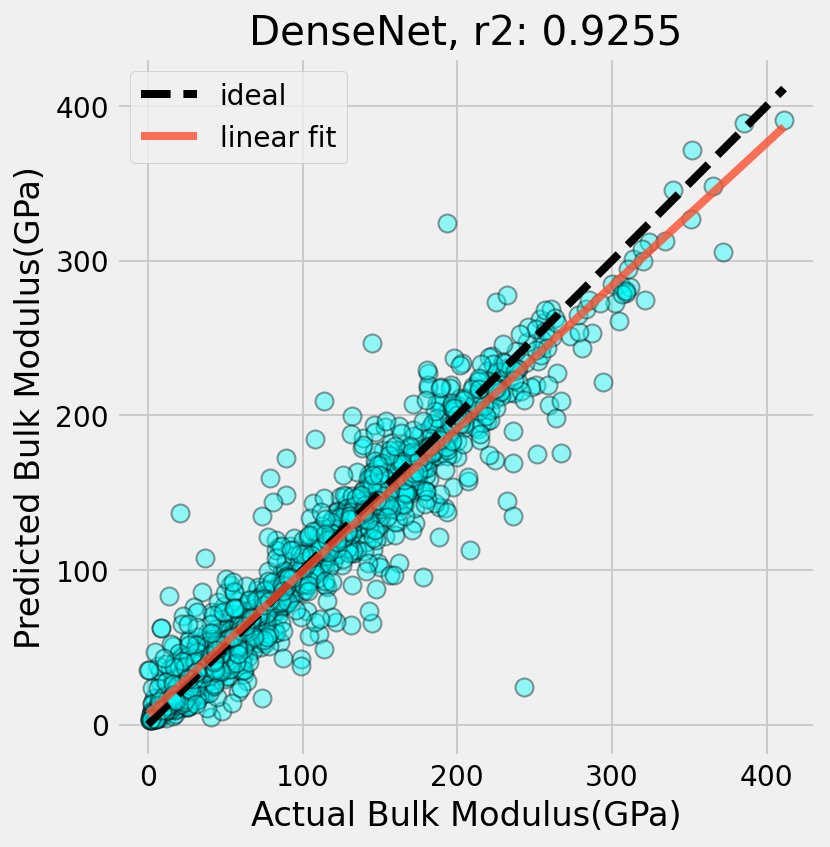

epoch: 420
epoch: 440
epoch: 460
epoch: 480
epoch: 499


In [17]:
data_type = torch.float
epochs = 500

print_every = 20
plot_every = 100

for epoch in range(epochs):
    if epoch % print_every == 0 or epoch == epochs - 1:
        print(f'epoch: {epoch}')
    if epoch % plot_every == 0:        
        target_train, pred_train = predict(model, train_loader)
        train_scores = evaluate(target_train, pred_train)
        print_scores(train_scores, label='train')
        
        target_val, pred_val = predict(model, val_loader)
        val_scores = evaluate(target_val, pred_val)
        print_scores(val_scores, label='val')
        plot_pred_act(target_val, pred_val, model, label='Bulk Modulus(GPa)')
        plt.show()
        
    for i, data_output in enumerate(train_loader):
        X, y = data_output
        y = target_scaler.scale(y)
        
        X = X.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)
        y = y.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)
        
        optimizer.zero_grad()
        output = model.forward(X).flatten()
        loss = criterion(output.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()
        

val r2: 0.9274
val mae: 11.9956
val rmse: 19.6199


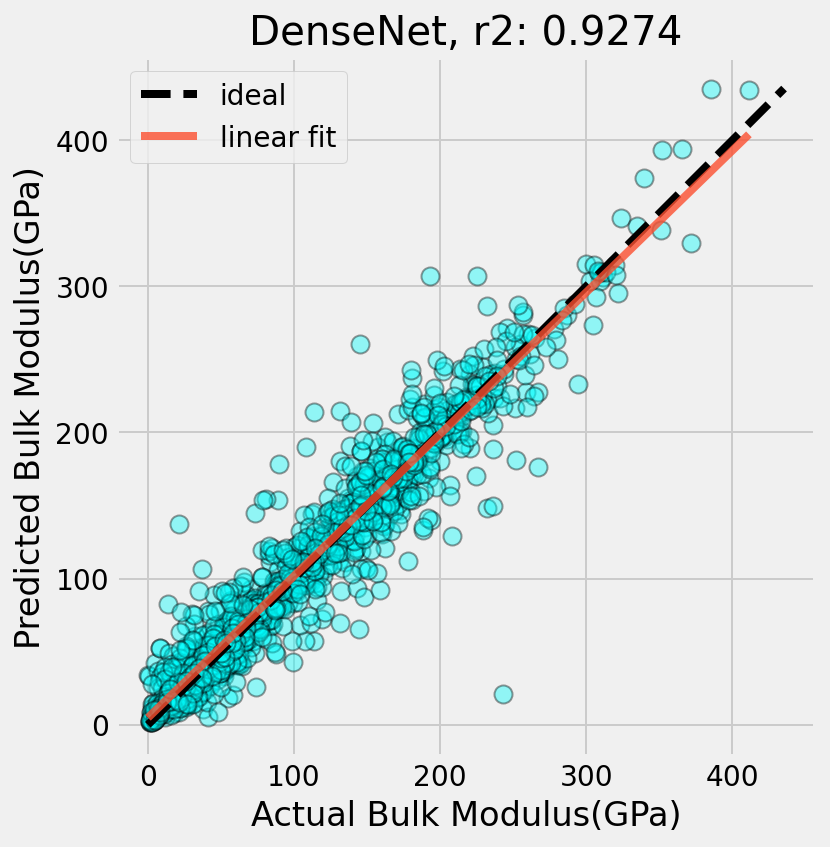

In [18]:
target_val, pred_val = predict(model, val_loader)
scores = evaluate(target_val, pred_val)

print_scores(scores, label='val')

plot = plot_pred_act(target_val, pred_val, model, label='Bulk Modulus(GPa)')

test r2: 0.8813
test mae: 12.0330
test rmse: 25.2892


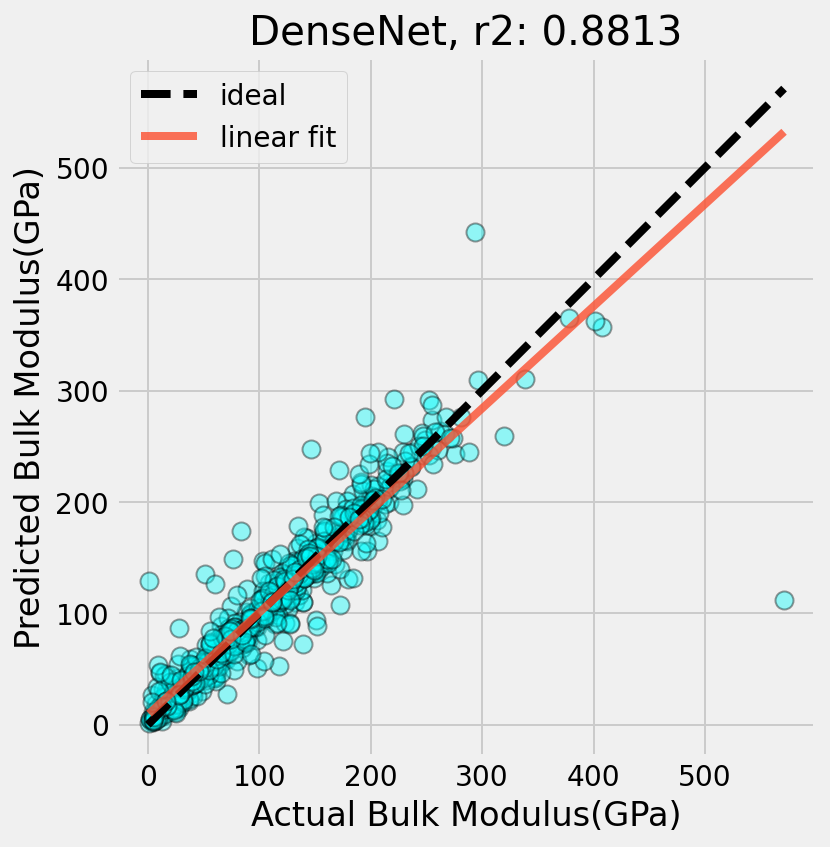

In [19]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='Bulk Modulus(GPa)')

In [20]:
save_dict = {'weights': model.state_dict(),
             'scaler_state': target_scaler.state_dict()}
print(save_dict)

{'weights': OrderedDict([('network.0.0.weight', tensor([[ -0.4335,  -0.0609,  -0.3535,  ...,  -1.7785,  -3.4125,   0.2239],
        [  0.0509,   0.2212,  -0.1604,  ...,   0.7053,   0.9345, -16.6252],
        [ -0.9741,  -0.7925,  -1.1329,  ...,  -0.8744,   1.7115, -16.1476],
        ...,
        [  0.3750,   0.9180,  -0.5149,  ...,  -0.4730,  -0.9120, -12.0342],
        [  0.2316,   0.4917,  -0.5903,  ...,  -0.5034,   1.4055, -17.1900],
        [  0.9908,   0.8842,   0.8967,  ...,   0.1619,  -0.0436,   1.4563]])), ('network.0.0.bias', tensor([ 0.2994, -1.0268, -1.2551,  0.0630, -1.0724, -0.4926, -0.5131,  0.4169,
        -0.3650,  0.1014, -0.4319,  0.0244, -0.1656, -0.6143, -0.8363, -0.3847])), ('network.1.weight', tensor([[ 0.1446, -0.7450, -1.6405,  0.1962, -0.5908,  0.1553, -0.5519, -0.1762,
         -0.2547,  0.1413,  0.1378, -0.1495,  0.1540, -0.4685, -0.6948,  0.1610]])), ('network.1.bias', tensor([0.1172]))]), 'scaler_state': {'mean': tensor(4.3369, dtype=torch.float64), 'std': 

In [21]:
pth_path = ('C:/Users/M PRAVEEN/OneDrive/AMRITA/steel/model_checkpoint.pth') # .pth is commonly used as the file extension
torch.save(save_dict, pth_path)

In [22]:
# First, clear the variables for model and target_scaler.
# We want to start with a clean slate.
model = None
target_scaler = None
del model
del target_scaler

In [23]:
# Instantiate the model.
# The model will be randomly initialized, but we will overwrite
# all weights and biases when we load the checkpoint.
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
model = model.to(compute_device)
print(model)

# Instantiate the target_scaler.
# We initialize this target_scaler with a vector of zeros,
# but we will overwrite its internal parameters
# when we load the checkpoint.
target_scaler = MeanLogNormScaler(torch.zeros(42))

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=310, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [24]:
# Load the checkpoint and map it to the compute device
pth_path = ('C:/Users/M PRAVEEN/OneDrive/AMRITA/steel/model_checkpoint.pth')
checkpoint = torch.load(pth_path, map_location=compute_device)

# Load the state dictionaries back into the model and target_scaler
model.load_state_dict(checkpoint['weights'])
target_scaler.load_state_dict(checkpoint['scaler_state'])

test r2: 0.8813
test mae: 12.0330
test rmse: 25.2892


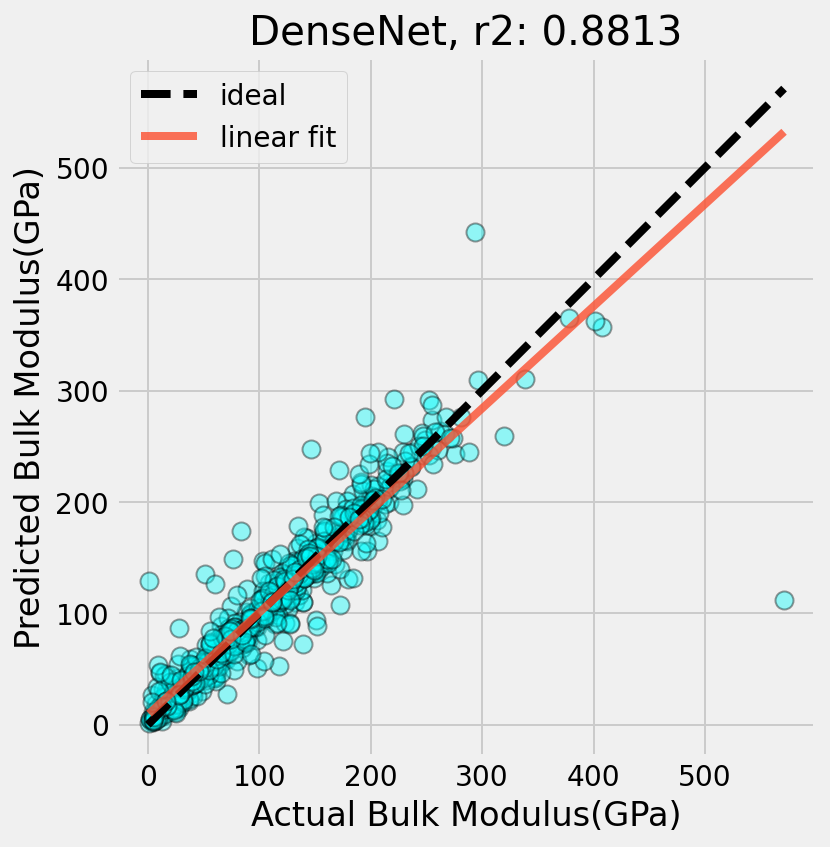

In [25]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='Bulk Modulus(GPa)')